In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
def load_data(path):
    x = None
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'rb') as f:
            tmp = tf.cast([np.load(f)], dtype=tf.float64)
            if x is None:
                x = tf.linalg.matmul(tmp, tmp, transpose_b=True)
            else:
                x = tf.concat([x, tf.linalg.matmul(tmp, tmp, transpose_b=True)], axis=0)
    return x

In [3]:
steps = 200
alphas, betas, gammas = [0.1, 1.0], [1000.0, 2000.0, 100.0], [0.01, 0.1]
# alphas, betas, gammas = [0.1], [1000.0, 2000.0], [0.01, 0.1]
# alphas, betas, gammas = [0.1], [1000.0], [0.01]
runs_per_k = 3

In [4]:
def fusion(x, k, alpha, beta, gamma):
    f = None
    n = x.shape[1]
    t = x.shape[0]
    reg = gamma / (4.0 * beta)
    wv, wv_u = tf.cast([1.0 / t for _ in range(t)], dtype=tf.float64), None
    i_alpha = tf.math.multiply(tf.eye(n, dtype=tf.float64), alpha)
    i_beta = tf.math.multiply(tf.eye(n, dtype=tf.float64), beta)
    s = tf.eye(n, dtype=tf.float64)
    for step in range(steps):
        s = tf.where(s > 0, s, tf.zeros(s.shape, dtype=tf.float64))
        s = tf.math.divide(tf.math.add(s, tf.transpose(s)), 2.0)
        z_sum = tf.zeros(s.shape, dtype=tf.float64)
        for i in range(t):
            z = tf.linalg.solve(
                tf.math.add(tf.math.add(x[i], i_alpha), tf.math.multiply(i_beta, wv[i])),
                tf.math.add(tf.math.multiply(s, tf.math.multiply(wv[i], beta)), x[i]))
            z = tf.where(z > 0, z, tf.zeros(z.shape, dtype=tf.float64))
            z = tf.math.divide(tf.math.add(z, tf.transpose(z)), 2.0)
            w = tf.math.divide(0.5, tf.norm(tf.math.subtract(z, s)))
            wv_u = tf.reshape(w, [1]) if i == 0 else tf.concat([wv_u, [w]], axis=0)
            z = tf.math.multiply(z, w)
            z_sum = tf.math.add(z_sum, z)

        l = tf.math.subtract(tf.linalg.diag(tf.math.reduce_sum(s, 0)), s)
        (_, f) = tf.linalg.eigh(l)
        f = tf.slice(f, [0, 0], [f.shape[0], k])
        p = tf.norm(tf.math.subtract(f[0][:], f), axis=1, keepdims=True)
        for i in range(1, n):
             p = tf.concat([p, tf.norm(tf.math.subtract(f[0][:], f), axis=1, keepdims=True)], 1)
        p = tf.math.multiply(tf.math.square(p), reg)
        wv = wv_u
        s_old = s
        s = tf.math.divide((tf.math.subtract(z_sum, p)), tf.math.reduce_sum(wv, 0))
        if step >= 4 and tf.math.less(tf.math.divide(tf.norm(tf.math.subtract(s, s_old)), tf.norm(s_old)), 1.e-4):
            print('Criterion found after', step + 1, 'steps')
            return f
    return f

In [5]:
from sklearn.cluster import KMeans

def run_k_means(k, f):
        k_means = KMeans(n_clusters=k, n_init=14).fit(f)
        cluster = k_means.labels_
        d = {}
        for i in cluster:
            if i in d:
                d[i] += 1
            else:
                d[i] = 1
        max_k = 0
        for i in d:
            max_k = max(max_k, d[i])
        if k in min_k:
            if max_k < min_k[k]:
                min_k[k] = max_k
                histograms[k] = d
                clusters[k] = cluster
                print('k:', k)
                print(d, '\nBiggest cluster:', max_k, '\n')
        else:
            min_k[k] = max_k
            histograms[k] = d
            clusters[k] = cluster
            print('k:', k)
            print(d, '\nBiggest cluster:', max_k, '\n')

In [6]:
def run_experiments(ks, views):    
    x = load_data(views)
    print(x.shape)
    for _ in range(runs_per_k):
        for k in ks:
            for alpha in alphas:
                for beta in betas:
                    for gamma in gammas:
                        print('Run with parameters', alpha, beta, gamma)
                        run_k_means(k, fusion(x, k, alpha, beta, gamma).numpy())

In [7]:
def save_np(name, matrix):
    with open(name + ".npy", 'wb') as f:
        np.save(f, matrix)

def save_results(folder):
    for k in clusters:        
        save_np(folder + str(k) + '_means', clusters[k])

In [8]:
histograms, min_k, clusters = {}, {}, {}
run_experiments([20, 30, 50, 70, 100, 150], 'views/profiles/')
save_results('clusters/profiles2/')
# save_results(run_experiments([70], 'views/profiles/'), 'profiles2')

(9, 423, 423)
Run with parameters 0.1 1000.0 0.01
Criterion found after 5 steps
k: 20
{16: 5, 12: 8, 1: 89, 13: 7, 2: 56, 15: 9, 9: 4, 17: 9, 19: 8, 10: 10, 6: 20, 18: 6, 3: 7, 0: 9, 5: 52, 8: 38, 4: 78, 7: 4, 11: 2, 14: 2} 
Biggest cluster: 89 

Run with parameters 0.1 1000.0 0.1
Criterion found after 5 steps
k: 20
{13: 14, 14: 8, 17: 39, 19: 3, 2: 54, 4: 9, 9: 10, 11: 75, 0: 8, 3: 10, 7: 17, 10: 2, 5: 7, 18: 9, 6: 49, 1: 60, 8: 34, 16: 11, 12: 2, 15: 2} 
Biggest cluster: 75 

Run with parameters 0.1 2000.0 0.01
Criterion found after 5 steps
k: 20
{13: 15, 18: 6, 3: 67, 10: 3, 1: 56, 5: 9, 9: 12, 15: 69, 14: 8, 16: 11, 7: 27, 8: 12, 12: 6, 4: 7, 11: 4, 2: 37, 17: 47, 0: 21, 19: 4, 6: 2} 
Biggest cluster: 69 

Run with parameters 0.1 2000.0 0.1
Criterion found after 5 steps
Run with parameters 0.1 100.0 0.01
Criterion found after 5 steps
Run with parameters 0.1 100.0 0.1
Criterion found after 5 steps
Run with parameters 1.0 1000.0 0.01
Criterion found after 5 steps
Run with parameters 

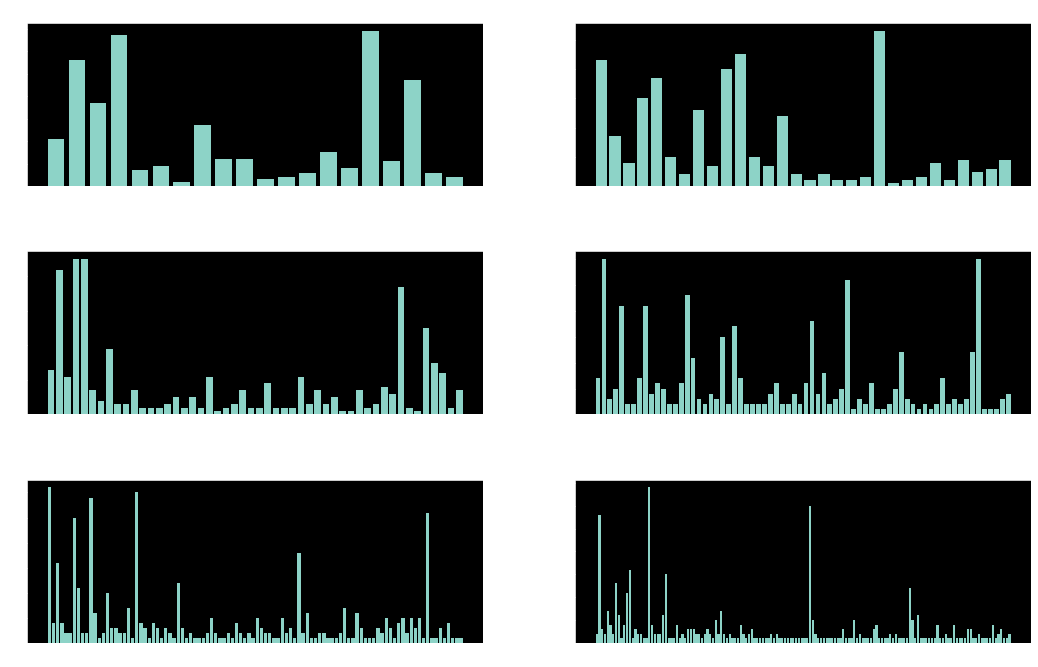

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 24))
plt.style.use('dark_background')

def plot_histograms():
    plt.subplots_adjust(hspace=0.4)
    cnt = 1
    for i in histograms:
        plt.subplot(len(histograms), 2, cnt)
        cnt += 1
        d = histograms[i]
        plt.bar(d.keys(), d.values())
        plt.title('k: ' + str(i))

plot_histograms()